# Simulación del tráfico en un carril.

**Gerardo Rivas Álvarez**

**César Bertoni Ocampo**

Se hará un modelo sencillo del tráfico de carros en un carril circular. La ecuación que hace esto es la siguiente

$$\dot{x_i} = mín\left( \frac{1}{T_i}(x_{i-1}-x_i -\frac{l_i + l_{i-1}}{2}),v_{max_{i}} \right).$$  

Lo que dice esta ecuación es que la velocidad del coche $i$ depende de la posición de este y del siguiente, $i+1$,  y es el mínimo entre la velocidad máxima del coche $i$ y una velocidad de cercanía que evita que haya accidentes.

In [2]:
#Llamando al paquete de Taylor
using TaylorSeries

Se necesita que las posiciones de los vehículos, así como las diferencias en estas, estén en módulo $2\pi$. Con ese fien, a continuación se escribe la función `modulo2pi` que encuentra la diferencia entre dos ángulos en módulo 2$\pi$. 

In [3]:
function modulo2pi(α,β)
    #Esta función calcula la diferencia entre dos ángulos y la devuelve 
    #módulo 2π.
    δ=α-β 
    
    if δ<0
        δ = 2π + δ
    else 
        δ = δ 
    end
    
    return δ
end

modulo2pi (generic function with 1 method)

La celda siguiente usa el paquete `TaylorSeries` para escribir dos funciones que escriben la serie de la derivada. `fSec()` crea la serie de Taylor de la velocidad de cercanía, mientras que `fmax()` escribe la serie correspondiente a la velocidad máxima.

In [4]:


#La siguiente función calcula los coeficientes de la velocidad de seguridad

function fSec{R<:Real }(T::R, car::TaylorSeries.Taylor1{R}, frontcar::TaylorSeries.Taylor1{R} , lfcar::R, Vmax::R)
    k = max(car.order, frontcar.order)
    
    vel = taylor1_variable(Float64, k)
     
    vel.coeffs[1] = 1/T * modulo2pi(frontcar.coeffs[1]-lfcar,car.coeffs[1])
    
    for i = 2 : k+1
        vel.coeffs[i] = 1/T * (frontcar.coeffs[i]-car.coeffs[i])
    end
        
    
    return vel
end

function fmax{R<:Real}(T::R, car::TaylorSeries.Taylor1{R}, frontcar::TaylorSeries.Taylor1{R} , lfcar::R, Vmax::R)
    vel = taylor1_variable(Float64,10)
    
    vel.coeffs[1] = Vmax
    vel.coeffs[2] = 0
    return vel
end

fmax (generic function with 1 method)

El método de integración de Taylor no tiene paso fijo. El paso se construyó de la siguiente forma
$$ h = \min\big[(\frac{\epsilon}{x^{[p]}}\big)^{1/p}\, \big] $$ con $p \in [1,k],$ donde $k$ es el orden del polinomio de Taylor con el que se está trabajando. La siguiente celda de código hace este cálculo para una serie dada.  

In [5]:
function stepsize{T<:Real}(x::TaylorSeries.Taylor1{T}, epsilon::Float64)
    ord = x.order
    h = Inf
    
    if ord > 1
        
        for k in [ord-1, ord]
            kinv = 1.0/k
            aux = abs( x.coeffs[k+1] )
            h = min(h, (epsilon/aux)^kinv)
        end
    
    elseif ord == 1
        
        
        
        aux = abs( x.coeffs[2])
        
        h = min(h, (epsilon/aux))
        
    end
        
    
    
    return h
end

stepsize (generic function with 1 method)

Se requiere elegir entre la velocidad máxima y la velocidad de cercanía de cada coche. Eso lo hace la siguiente función, que devuelve un arreglo hecho con la velocidad correspondiente a cada coche, dependiendo de sus posiciones.

In [6]:
function speed(intPos::Array{Float64,1}, carL::Array{Float64,1}, carτ::Array{Float64,1}, carV::Array{Float64,1})
    #Esta función decide la función que debe generar la serie de cada carro.
    
    n = length(intPos)
    F = Function[]
   
    #F será un arreglo de funciones, una función para cada carro.
    
    for j in 1:n-1
        
        a = (modulo2pi(intPos[j+1],intPos[j])-carL[j+1])/carτ[j] #Checa la distancia al coche de enfrente.
        b = carV[j]
        
        if a < b #Compara las velocidades y decide que función aplicar al coche j
            push!(F,fSec)
        else
            push!(F,fmax)
        end
        
    end
    #El coche que está delante del enésimo es el coch 1. Se debe cerrar la cadena.
    
    a = (modulo2pi(intPos[1],intPos[n])-carL[1])/carτ[n]
    b = carV[n]
    
    if a < b
        push!(F,fSec)
    else
        push!(F,fmax)
    end
    
    return F
    
end


speed (generic function with 1 method)

A continuación se hizo una función que calcula los polinomios de Taylor, truncados a grado 10, de las posiciones de los coches. Para encontrar los coeficientes se usó  
$$ x_{n+1} = \frac{f_n}{n+1}. $$

In [7]:
function Taylorcars(initPos::Array{Float64,1}, carL::Array{Float64,1}, carτ::Array{Float64,1}, carV::Array{Float64,1})
    
    n = length(initPos)
    
    Xcars = TaylorSeries.Taylor1{Float64}[]
    
    #El siguiente cilco llena el arreglo Xcars con taylors que sólo tienen el coeficiente de orden cero.
    for i in 1:n
        x = taylor1_variable(Float64,10)
        x.coeffs[1] = initPos[i]
        x.coeffs[2] = 0
        
        push!(Xcars,x)
    end
    
    #Se aplica la función speed para conocer la velocidad que tendrá cada carro
    F = speed(initPos::Array{Float64,1}, carL::Array{Float64,1}, carτ::Array{Float64,1}, carV::Array{Float64,1})
    
    #Una vez conociendo la velocidad se puede proseguir a calcular coeficientes de las series de taylor de órdenes mayores
    for i in 1:n-1
        for j in 2:11
            #Solo se aplica la fórmula de recurrencia.
            Xcars[i].coeffs[j] = F[i](carτ[i], Xcars[i], Xcars[i+1] , carL[i+1] , carV[i] ).coeffs[j-1]/(j-1) #se divide entre j-1 para corregir el desfase de los Taylor1 en los coeffs.
        end
    end
    
    #Al igual que con la velocidad, el último coche debe cerrar el ciclo. Tiene enfrente al coche 1.
    for j in 2:11
            
        Xcars[n].coeffs[j] = F[n](carτ[n], Xcars[n], Xcars[1] , carL[1] , carV[n] ).coeffs[j-1]/(j-1) #se divide entre j-1 para corregir el desfase de los Taylor1 en los coeffs.
    end
    
    return Xcars
    
end

Taylorcars (generic function with 1 method)

La función `hselector()` toma el paso más pequeño de entre todos los carros. 

In [8]:
#Seleccionamos el tamano de la h que vamos a usar para eso generamos un arreglo de h y elejiremos la más chica de ellas
#dada una épsilon
function hselector(seriecoches,ϵ)
    n=length(seriecoches)
    hs = Float64[]
    
    for i in 1:n
        h=stepsize(seriecoches[i],ϵ)
        push!(hs,h)
    end
    
    minabs(hs)
end

hselector (generic function with 1 method)

En la siguiente celda se encuentran dos funciones, una va registrando las posiciones de los coches en un arreglo, esta función es escencial para conocer la posición de los coches como función de t. La otra función almacena las velocidades.

In [9]:
function positions(tayse,h) #Calcula las nuevas posiciones
    x=Float64[];
    n=length(tayse)
    
    for i in 1:n
        pos= evaluate(tayse[i],h)
        if pos >= 2π
            pos = mod2pi(pos)
        end
        push!(x,pos)
    end
    
    return x
end

function celeritates(tayse,h) #Calcula las nuevas velocidades
    v=Float64[];
    n=length(tayse)
    
    for i in 1:n
        ves= evaluate(diffTaylor(tayse[i]),0) #hace las primeras derivadas de las series de taylor de cada coche y las evalua
        push!(v,ves)
    end
    
    return v
end

celeritates (generic function with 1 method)

In [10]:
function pasamodulo2pi(arreglo)#Converte el valor de las posiciones a un valor modulo 2π
    n=length(arreglo);
    nuevarreg = Float64[];
    for i in 1:n
        nueva = mod2pi(arreglo[i])
        push!(nuevarreg,nueva)
    end
    nuevarreg
end

pasamodulo2pi (generic function with 1 method)

Después, sólo falta implementar el método de Taylor, esto es, aplicar todas las funciones descritas arriba para pararnos en un punto, alrededor de este encontrar el polinomio de Taylor, buscar el siguiente paso, evaluar el polinomio con este paso temporal para encontrar la siguiente posición y repetir el proceso.

In [11]:
#Ahora vamos a correr el método de Taylor.
function Taypos(X0, L, Τ, V,tf,ϵ,ti=0.0)
    tempore = Float64[ti]; #Arreglo de tiempo
    loca = Vector{Float64}[X0]; #Arreglo de arreglo de posiciones
    celerita = Vector{Float64}[V]; #Arreglo de arreglo de velocidades
    haches = Float64[0] #Este arreglo nos servirá para las animaciones

    
    while ti <= tf
        tayseries = Taylorcars(X0, L, Τ, V)
        h = hselector(tayseries,ϵ)
        xs = positions(tayseries,h)
        vs = celeritates(tayseries,h)
        ti = ti+h
        push!(tempore,ti)
        push!(loca,[xs;])
        push!(celerita, [vs;])
        push!(haches, h)
        X0 = xs

    end 
    
    [tempore hcat(loca...)' hcat(celerita...)' haches;]
    
end

Taypos (generic function with 2 methods)

Ahora queda probar la función. Primero con 3 carros, los parámetros se pueden ver a continuación.

In [12]:
X0x = [0,0.3,7*π/4];
L = π/100 * [1,1,1];
Τ = [1.0,1.0,1.0];
V = [1.0, 1.4, 2.2]
tf = 13;
ϵ = 2.0e-20;

In [14]:
x=Taypos(X0x,L,Τ,V,tf,ϵ);

In [15]:
Libdl.dlopen("/usr/lib/liblapack.so.3", Libdl.RTLD_GLOBAL)
using PyPlot
using PyCall

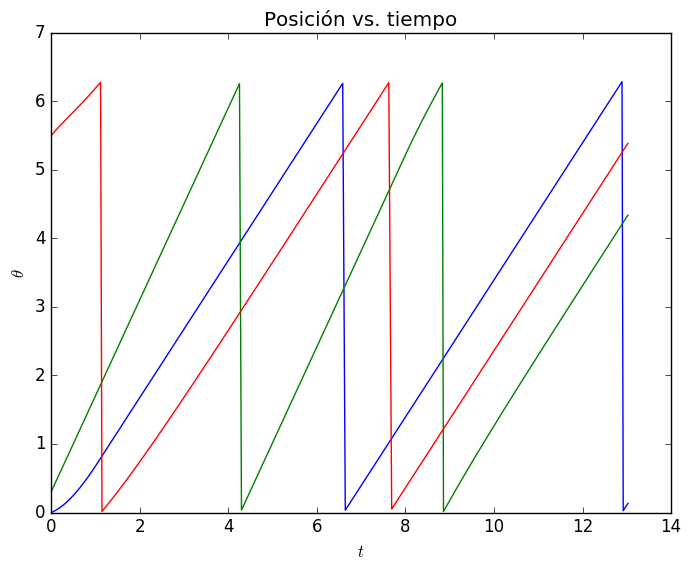

PyObject <matplotlib.text.Text object at 0x7fb20afb7050>

In [16]:
for i in 2:4
    plot(x[:,1],x[:,i])
end
xlabel(L"t")
ylabel(L"\theta")
title("Posición vs. tiempo")

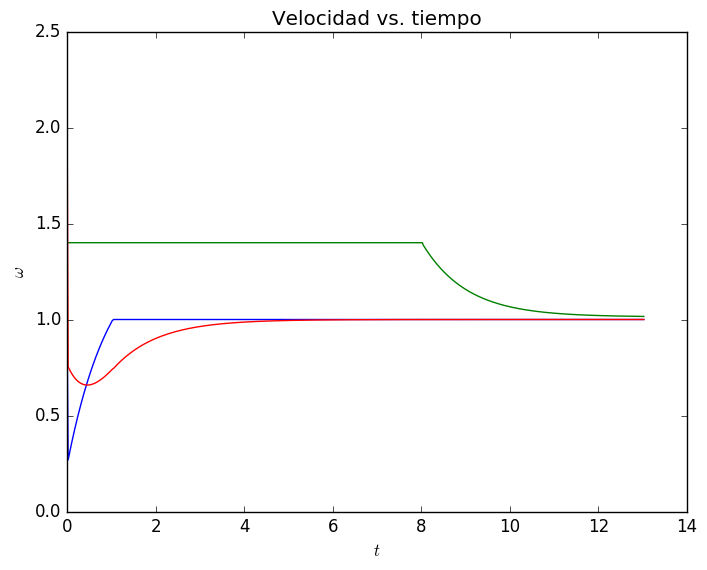

PyObject <matplotlib.text.Text object at 0x7fb20ae67a10>

In [17]:
for i in 5:7
    plot(x[:,1], x[:,i])
end
xlabel(L"t")
ylabel(L"\omega")
title("Velocidad vs. tiempo")

In [18]:
X0 = [0,π/8,π/2,15*π/8, π];
X0y1 = sort(X0);
L = π/100 * [1.0,1.0,1.0,1.0,1.0];
T = [1.0,1.0,0.2,1.0,1.0];
V = [π/3,π/2,π/4,π\3,π/7];
tf = 25;
ϵ = 2.0e-20;

In [19]:
y1=Taypos(X0y1,L,T,V,tf,ϵ);

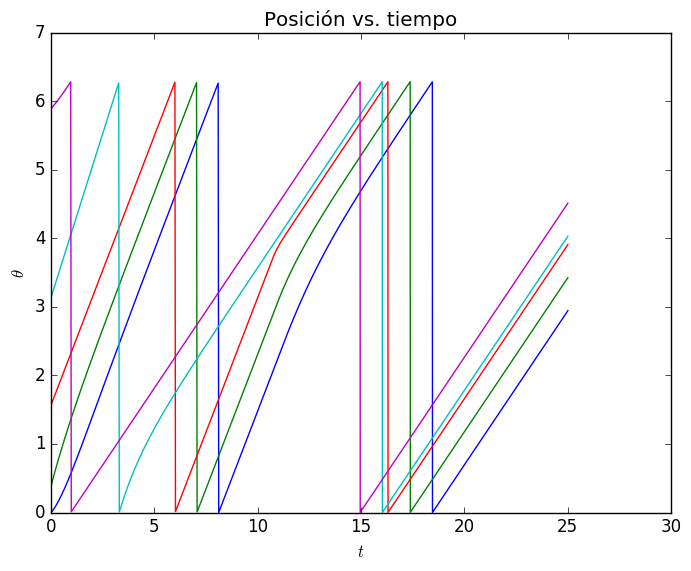

PyObject <matplotlib.text.Text object at 0x7fb20ad67150>

In [20]:
n = length(X0y1)
for i in 2:n+1
    plot(y1[:,1], y1[:,i])
end
xlabel(L"t")
ylabel(L"\theta")
title("Posición vs. tiempo")

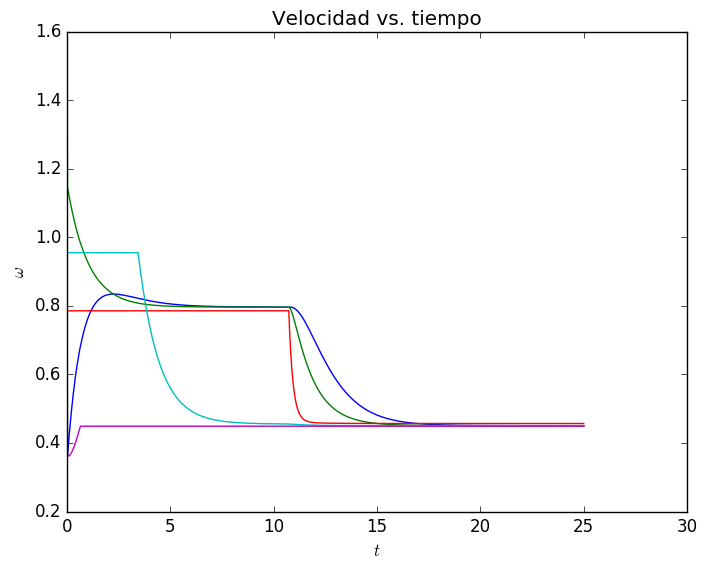

PyObject <matplotlib.text.Text object at 0x7fb20acb5090>

In [21]:
for i in n+2:2*n+1
    plot(y1[:,1], y1[:,i])
end
xlabel(L"t")
ylabel(L"\omega")
title("Velocidad vs. tiempo")

In [22]:
#Se pondrá un tope en pi

function fSec{R<:Real }(T::R, car::TaylorSeries.Taylor1{R}, frontcar::TaylorSeries.Taylor1{R} , lfcar::R, Vmax::R)
    k = max(car.order, frontcar.order)
    
    vel = taylor1_variable(Float64, k)
     
    vel.coeffs[1] = 1/T * (modulo2pi(frontcar.coeffs[1]-lfcar,car.coeffs[1]))
   
    if 0< π - car.coeffs[1] < π/8
        vel.coeffs[1] = 1/(2*T) * (modulo2pi(frontcar.coeffs[1]-lfcar,car.coeffs[1]))
    end
    
    for i = 2 : k+1
        vel.coeffs[i] = 1/T * (frontcar.coeffs[i]-car.coeffs[i])
    end
        
    
    return vel
end

function fmax{R<:Real}(T::R, car::TaylorSeries.Taylor1{R}, frontcar::TaylorSeries.Taylor1{R} , lfcar::R, Vmax::R)
    vel = taylor1_variable(Float64,10)
    
    vel.coeffs[1] = Vmax
    vel.coeffs[2] = 0
    
    if 0< π - car.coeffs[1] < π/8
        vel.coeffs[1] = Vmax/2
    end
        return vel
end

fmax (generic function with 1 method)

In [23]:
X0 = [0,π/8,π/2,15*π/8, π];
X0y2 = sort(X0);
L = π/100 * [1.0,1.0,1.0,1.0,1.0];
T = [1.0,1.0,0.2,1.0,1.0];
V = [π/3,π/2,π/4,π\3,π/7];
tf = 40;
ϵ = 2.0e-20;

In [24]:
y2=Taypos(X0y2,L,T,V,tf,ϵ);

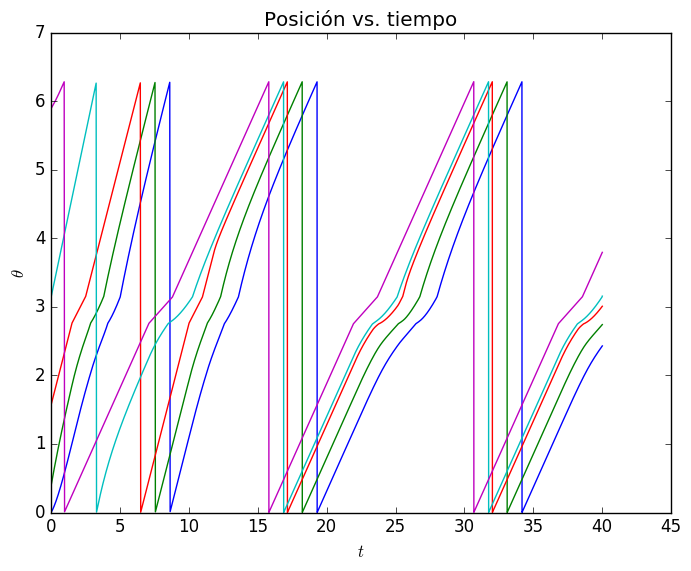

PyObject <matplotlib.text.Text object at 0x7fb20ac08210>

In [25]:
n = length(X0y2)
for i in 2:n+1
    plot(y2[:,1], y2[:,i])
end
xlabel(L"t")
ylabel(L"\theta")
title("Posición vs. tiempo")

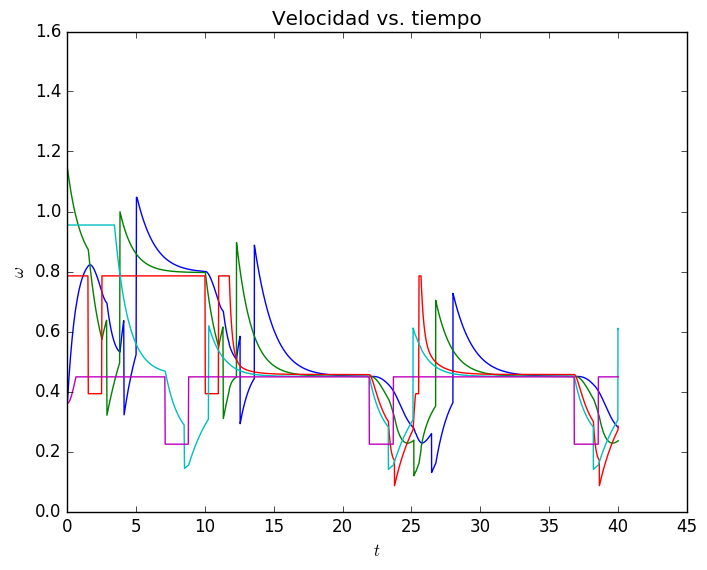

PyObject <matplotlib.text.Text object at 0x7fb20aae6f10>

In [26]:
for i in n+2:2*n+1
    plot(y2[:,1], y2[:,i])
end
xlabel(L"t")
ylabel(L"\omega")
title("Velocidad vs. tiempo")

Por el tiempo que toma el renderizado del las animaciones se previó pertinente dejar esto hasta el final. 

In [ ]:
p=length(x[:,1])
n=length(X0x);
for i in 1:p
    fig = figure(); # Se crea una nueva figura
    ax = axes(polar="true"); # Se crean ejes coordenados polares
    ax[:set_theta_zero_location]("E"); # Se coloca la medida de 0 grados a la derecha
    for k in 1:n
        r=round(abs(k/n),3);       #Funciones para el color en esquema RGB
        g=round(abs(sin(π*n/k)),3);
        b=round(abs(cos(π*n/k)),3);
        ax[:bar](x[i,k+1],1, width=L[k], bottom=0.9,color=[r g b]);
    end
    savefig("3carros_$(i).png");
end

In [ ]:
p=length(y1[:,1])
n=length(X0y1);
for i in 1:p
    fig = figure(); # Se crea una nueva figura
    ax = axes(polar="true"); # Se crean ejes coordenados polares
    ax[:set_theta_zero_location]("E"); # Se coloca la medida de 0 grados a la derecha
    for k in 1:n
        r=round(abs(k/n),3);       #Funciones para el color en esquema RGB
        g=round(abs(sin(π*n/k)),3);
        b=round(abs(cos(π*n/k)),3);
        ax[:bar](y1[i,k+1],1, width=L[k], bottom=0.9,color=[r g b]);
    end
    savefig("5carros_$(i).png");
end

In [ ]:
p=length(y2[:,1])
n=length(X0y2);
for i in 1:p
    fig = figure(); # Se crea una nueva figura
    ax = axes(polar="true"); # Se crean ejes coordenados polares
    ax[:set_theta_zero_location]("E"); # Se coloca la medida de 0 grados a la derecha
    for k in 1:n
        r=round(abs(k/n),3);       #Funciones para el color en esquema RGB
        g=round(abs(sin(π*n/k)),3);
        b=round(abs(cos(π*n/k)),3);
        ax[:bar](y2[i,k+1],1, width=L[k], bottom=0.9,color=[r g b]);
    end
    savefig("tope_$(i).png");
end

Puede ser necesario instalar ciertos paquetes para generar la animación, en caso de no tener instalado ffmpeg o avconv.

In [ ]:
;sudo apt-get install libav-tools libavcodec-extra-53 libavdevice-extra-53 libavformat-extra-53 libavutil-extra-51 libpostproc-extra-52 libswscale-extra-2

Lo que sigue es generar los videos de cada una de los casos considerados, lo hacemos con el siguiente comando en una terminal. Lo vamos a generar en un video mkv (o .mov si cambiamos la extensión de salida) a 30 fps. 

In [ ]:
;avconv -i "3carros_%d.png" -r 30 -c:v libx264 -crf 23  -pix_fmt yuv420p carros3.mov
;avconv -i "5carros_%d.png" -r 30 -c:v libx264 -crf 23  -pix_fmt yuv420p carros5.mkv
;avconv -i "tope_%d.png" -r 30 -c:v libx264 -crf 23  -pix_fmt yuv420p tope.mkv